# Install

In [7]:
# !pip install git+https://github.com/seoyeonc/ebayesthresh.git

  Cloning https://github.com/seoyeonc/ebayesthresh.git to /tmp/pip-req-build-gh560sa9
  Running command git clone --filter=blob:none --quiet https://github.com/seoyeonc/ebayesthresh.git /tmp/pip-req-build-gh560sa9
  Resolved https://github.com/seoyeonc/ebayesthresh.git to commit ed192d245edf36cd7b6df5ae8ae4b217ae63ac5a
  Preparing metadata (setup.py) ... done
  Created wheel for ebayesthresh: filename=ebayesthresh-0.0.1-py3-none-any.whl size=9740 sha256=da51a5730cd887fcf5e57fc12269c64cdb8626b7257caffa19d05f7bc5c344f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-6lix5_1s/wheels/64/9a/27/4ae710bcecb5e9068c9cf7034acefa27666251c621442dc422
Successfully built ebayesthresh


# Import

In [2]:
import ebayesthresh

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 예제를 위해 필요한 함수 정의

In [4]:
def make_Psi(T):
    W = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                W[i,j] = 0
            elif np.abs(i-j) <= 1 : 
                W[i,j] = 1
    d = np.array(W.sum(axis=1))
    D = np.diag(d)
    L = np.array(np.diag(1/np.sqrt(d)) @ (D-W) @ np.diag(1/np.sqrt(d)))
    lamb, Psi = np.linalg.eigh(L)
    return Psi

# Example

In [16]:
T = 100
x = np.arange(T)/T * 10
y_true = 3*np.sin(0.5*x) + 1.2*np.sin(1.0*x) + 0.5*np.sin(1.2*x) 
y = y_true + np.random.normal(size=T)

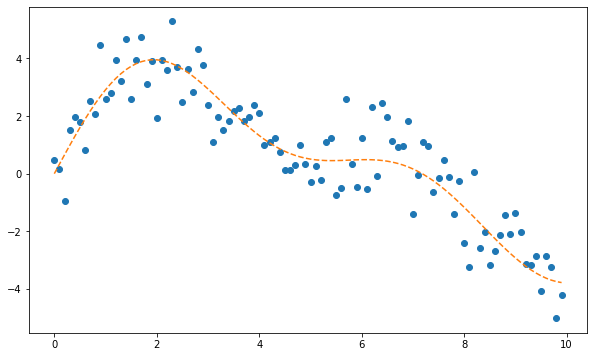

In [17]:
plt.figure(figsize=(10,6))
plt.plot(x,y,'o')
plt.plot(x,y_true,'--')

In [18]:
f = np.array(y)
if len(f.shape)==1: f = f.reshape(-1,1)
T,N = f.shape
Psi = make_Psi(T)
fbar = Psi.T @ f # apply dft 

In [19]:
fbar_threshed = ebayesthresh.ebayesthresh(fbar[:,0])

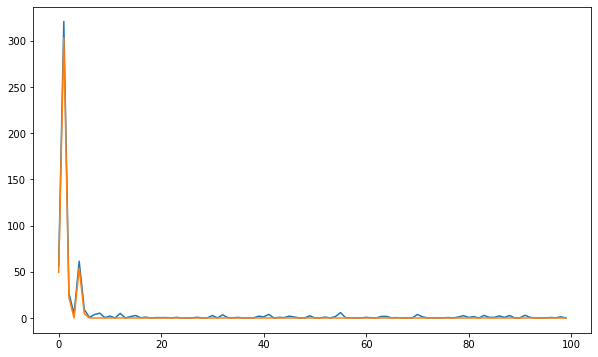

In [20]:
plt.figure(figsize=(10,6))
plt.plot((fbar**2)) # periodogram 
plt.plot((fbar_threshed**2)) 

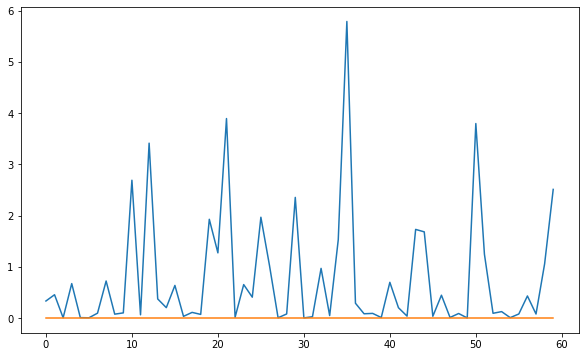

In [21]:
plt.figure(figsize=(10,6))
plt.plot((fbar**2)[20:80]) # periodogram 
plt.plot((fbar_threshed**2)[20:80]) 

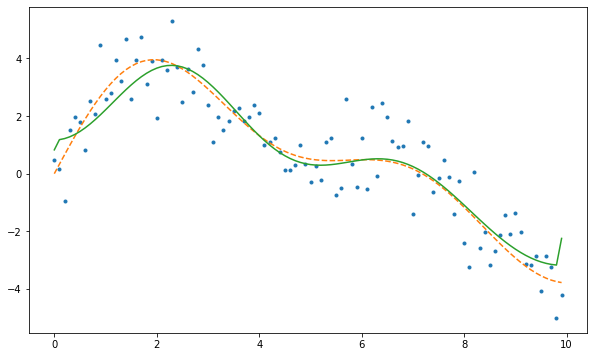

In [22]:
yhat = Psi @ fbar_threshed # inverse dft
plt.figure(figsize=(10,6))
plt.plot(x,y,'.')
plt.plot(x,y_true,'--')
plt.plot(x,yhat)

# 사용자 함수 정의 

In [83]:
torch.tensor(0.0,requires_grad=True)

tensor(0., requires_grad=True)

In [102]:
class ebayesthresh_nn(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.bayesfac = kwargs.get("bayesfac",True)
        self.verbose = kwargs.get('verbose', True)
        self.threshrule = kwargs.get('threshrule', 'median')
        self.universalthresh = kwargs.get('universalthresh', True)
        self.stabadjustment = kwargs.get('stabadjustment', None)
        self.prior = kwargs.get('prior', 'laplace')
        self.bayesfac = kwargs.get('bayesfac', False) 
        #--#
        self.a = torch.tensor(0.1,requires_grad=True); self.a.data = torch.tensor(kwargs.get('a', 0.5)).float()
        self.sdev = torch.tensor(0.1,requires_grad=True); self.sdev =  torch.tensor(kwargs.get('sdev', 0.5)).float()
        #prior="laplace", a = 0.5, bayesfac = False, sdev = None, verbose = True, threshrule = "median", universalthresh = True, stabadjustment = None
    def thresh(self):
        bayesfac= self.bayesfac
        verbose = self.verbose
        threshrule = self.threshrule
        universalthresh = self.universalthresh
        stabadjustment = self.stabadjustment
        prior = self.prior 
        bayesfac = self.bayesfac 
        #--#
        a = self.a 
        sdev = self.sdev

        if sdev is None:
            sdev = mad(x, center=0)
            stabadjustment_condition = True
        elif len(np.atleast_1d(sdev)) == 1:
            if stabadjustment is not None:
                raise ValueError("Argument stabadjustment is not applicable when variances are homogeneous.")
            if np.isnan(sdev):
                sdev = mad(x, center=0)
            stabadjustment_condition = True
        else:
            if pr == "c":
                raise ValueError("Standard deviation has to be homogeneous for Cauchy prior.")
            if len(sdev) != len(x):
                raise ValueError("Standard deviation has to be homogeneous or have the same length as observations.")
            if stabadjustment is None:
                stabadjustment = False
            stabadjustment_condition = stabadjustment

        if stabadjustment_condition:
            m_sdev = np.mean(sdev)
            s = sdev / m_sdev
            x = x / m_sdev
        else:
            s = sdev

        if (pr == "l") and np.isnan(a):
            pp = wandafromx(x, s, universalthresh)
            w = pp['w']
            a = pp['a']
        else:
            w = wfromx(x, s, prior=prior, a=a, universalthresh=universalthresh)

        if pr != "m" or verbose:
            tt = tfromw(w, s, prior=prior, bayesfac=bayesfac, a=a)[0]
            if stabadjustment_condition:
                tcor = tt * m_sdev
            else:
                tcor = tt

        if threshrule == "median":
            muhat = postmed(x, s, w, prior=prior, a=a)
        elif threshrule == "mean":
            muhat = postmean(x, s, w, prior=prior, a=a)
        elif threshrule == "hard":
            muhat = threshld(x, tt)
        elif threshrule == "soft":
            muhat = threshld(x, tt, hard=False)
            if threshrule == "none":
                muhat = None
        else:
            raise ValueError(f"Unknown threshold rule: {threshrule}")

        if stabadjustment_condition:
            muhat = muhat * m_sdev

        if not verbose:
            return muhat
        retlist = {
                'muhat': muhat,
                'x': x,
                'threshold.sdevscale': tt,
                'threshold.origscale': tcor,
                'prior': prior,
                'w': w,
                'a': a,
                'bayesfac': bayesfac,
                'sdev': sdev,
                'threshrule': threshrule
            }
        if pr == "c":
            del retlist['a']
        if threshrule == "none":
            del retlist['muhat']
        return retlist
    def forward(self,x):
        out = ebayesthresh.ebayesthresh(
            x,
            self.prior, 
            a=self.a, 
            bayesfac=self.bayesfac, 
            sdev=self.sdev, 
            verbose=self.verbose, 
            threshrule=self.threshrule, 
            universalthresh=self.universalthresh, 
            stabadjustment=self.stabadjustment
        )
        return out

> 데이터

In [103]:
np.random.seed(111)
T = 100
x = np.arange(T)/T * 10
ytrue = 3*np.sin(0.5*x) + 1.2*np.sin(1.0*x) + 0.5*np.sin(1.2*x) 
noise  = np.random.normal(size=T)*0.7
y = ytrue + noise

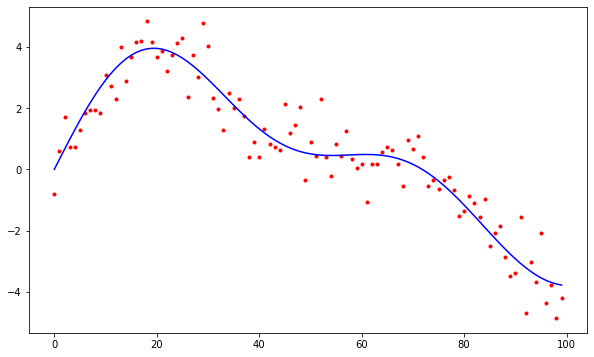

In [104]:
plt.figure(figsize=(10,6))
plt.plot(y,'.',color='r')
plt.plot(ytrue,'-',color='b')

> 레이어 정의

In [105]:
thresh_layer = ebayesthresh_nn()

> Fourier Transform

In [106]:
Psi = make_Psi(T)

In [107]:
ybar = Psi.T @ y

> Learn

In [ ]:
ebayesthresh.ebayesthresh??

Signature:
ebayesthresh.ebayesthresh(
    x,
    prior='laplace',
    a=0.5,
    bayesfac=False,
    sdev=None,
    verbose=False,
    threshrule='median',
    universalthresh=True,
    stabadjustment=None,
)
Docstring: <no docstring>
Source:   
def ebayesthresh(x, prior="laplace", a=0.5, bayesfac=False, sdev=None, verbose=False, threshrule="median", universalthresh=True, stabadjustment=None):
    pr = prior[0:1]

    if sdev is None:
        sdev = mad(x, center=0)
        stabadjustment_condition = True
    elif len(np.atleast_1d(sdev)) == 1:
        if stabadjustment is not None:
            raise ValueError("Argument stabadjustment is not applicable when variances are homogeneous.")
        if np.isnan(sdev):
            sdev = mad(x, center=0)
        stabadjustment_condition = True
    else:
        if pr == "c":
            raise ValueError("Standard deviation has to be homogeneous for Cauchy prior.")
        if len(sdev) != len(x):
            raise ValueError("Standard deviati

In [99]:
power_threshed = thresh_layer(torch.tensor(ybar))

TypeError: mean() received an invalid combination of arguments - got (dtype=NoneType, out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


> Inverse Fourier Transform

In [30]:
ytrue_hat = Psi@power_threshed['muhat']

In [31]:
power_threshed

{'muhat': array([  6.42453566, -18.27981487,  -5.36813323,   0.        ,
         -7.57307354,   0.69758938,  -2.55666216,  -0.        ,
          0.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,  -0.        ,  -0.        ,  -0.        ,
          0.        ,  -0.        ,   0.        ,  -0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
         -0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  -0.        ,   0.        ,   0.        ,
         -0.        ,   0.        ,  -0.        ,   0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,   0.        ,  -0.        ,  -0.        ,
          0.        ,   0.        ,   0.        ,  -0.        ,
         -0.        ,   0.        ,   0.        ,  -0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
         -0.        ,  -0.     

> Result

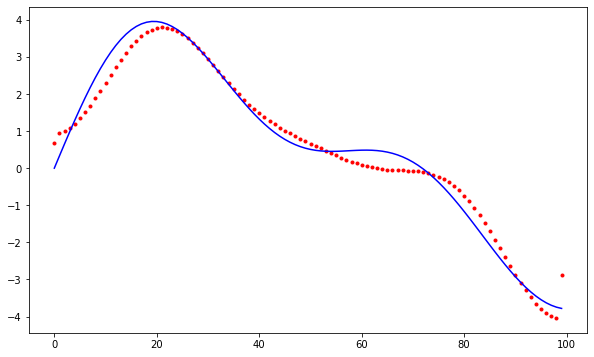

In [32]:
plt.figure(figsize=(10,6))
plt.plot(ytrue_hat,'.',color='r')
plt.plot(ytrue,'-',color='b')

> MSE

In [47]:
y = torch.tensor(y)
ytrue_hat = torch.tensor(ytrue_hat,requires_grad=True)

In [48]:
loss = torch.sum((y- ytrue_hat)**2)
loss

tensor(50.2861, dtype=torch.float64, grad_fn=<SumBackward0>)

In [49]:
ytrue_hat.grad

In [50]:
loss.backward()

In [51]:
ytrue_hat.grad

tensor([ 2.9195,  0.7201, -1.3920,  0.7190,  0.9161,  0.1220, -0.7026, -0.4869,
        -0.0884,  0.4602, -1.5615, -0.3885,  0.8501, -2.1748,  0.4428, -0.7604,
        -1.4611, -1.2501, -2.3386, -0.8789,  0.2302, -0.1631,  1.1447,  0.0221,
        -0.8889, -1.3406,  2.2993, -0.7001,  0.4186, -3.3630, -2.1764,  0.9073,
         1.3142,  2.3474, -0.4366,  0.2822, -0.6091,  0.1923,  2.6515,  1.3788,
         2.1354,  0.1095,  0.8709,  0.8678,  0.9315, -2.2676, -0.5263, -1.1352,
        -2.4840,  2.1805, -0.4385,  0.2941, -3.5019,  0.1060,  1.2290, -0.9767,
        -0.2687, -2.0383, -0.3204,  0.1575, -0.1681,  2.2191, -0.3186, -0.3580,
        -1.1659, -1.5349, -1.3802, -0.4360,  0.9556, -2.0545, -1.4892, -2.3337,
        -1.0227,  0.8117,  0.3780,  0.8228,  0.0866, -0.2766,  0.3736,  1.8458,
         1.2516, -0.0851,  0.0654,  0.5813, -0.9866,  1.6026,  0.3054, -0.6239,
         0.9239,  1.7057,  1.0228, -3.0392,  2.8222, -0.9495,  0.0268, -3.4367,
         0.9180, -0.4054,  1.6353,  2.68

In [53]:
ytrue_hat/y

tensor([-0.8392,  1.6014,  0.5916,  1.4922,  1.6166,  1.0477,  0.8103,  0.8736,
         0.9770,  1.1239,  0.7466,  0.9283,  1.1848,  0.7291,  1.0765,  0.8963,
         0.8246,  0.8507,  0.7580,  0.8948,  1.0314,  0.9790,  1.1779,  1.0029,
         0.8925,  0.8433,  1.4889,  0.9061,  1.0690,  0.6479,  0.7297,  1.1953,
         1.3358,  1.9186,  0.9130,  1.0707,  0.8672,  1.0549,  4.4013,  1.7639,
         3.6095,  1.0416,  1.5207,  1.5814,  1.7401,  0.4724,  0.7812,  0.6044,
         0.3909, -2.0195,  0.7513,  1.3270,  0.2330,  1.1278, -1.9387,  0.4137,
         0.6805,  0.1846,  0.5278,  2.4833,  0.5161, -0.0501,  0.1215, -0.0175,
        -0.0404, -0.0509, -0.0740, -0.3364,  0.1127, -0.0695, -0.1119, -0.0810,
        -0.2631,  0.2489,  0.4786,  0.3543,  0.8712,  1.5791,  0.7195,  0.3940,
         0.5418,  1.0497,  0.9705,  0.8136,  1.5013,  0.6794,  0.9266,  1.1684,
         0.8387,  0.7558,  0.8488,  1.9669,  0.7003,  1.1576,  0.9964,  1.8279,
         0.8949,  1.0535,  0.8317,  0.68

In [56]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.SGD(thresh_layer.parameters(), lr=0.01)

ValueError: optimizer got an empty parameter list

In [52]:


# 학습
num_epochs = 1000  # 에폭 수
for epoch in range(num_epochs):
    # 순전파
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    
    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 로그 출력
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 학습된 모델을 통해 예측
predicted = model(x_tensor).detach().numpy()

tensor(50.2861, dtype=torch.float64, grad_fn=<SumBackward0>)

In [57]:
??torch.nn.Linear

Init signature:
torch.nn.Linear(
    in_features: int,
    out_features: int,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Source:        
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

 